# Imports


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import os # Added for saving segments

# Custom DFS-based Connected Components Algorithm

In [ ]:
def custom_connected_components_dfs(binary_image_input, connectivity=4):
    """
    Performs Connected Components Analysis (CCA) using Depth-First Search (DFS).
    This function identifies and labels distinct foreground regions (connected pixels)
    in a binary image.

    Args:
        binary_image_input (np.ndarray): A 2D binary image.
                                         Foreground pixels (regions to be analyzed) should be 255.
                                         Background pixels (edges or empty space) should be 0.
        connectivity (int): Defines how pixels are considered connected.
                            4: Only horizontal and vertical neighbors.
                            8: Horizontal, vertical, and diagonal neighbors.

    Returns:
        tuple: Contains detailed information about each detected connected component.
               - total_components_found (int): The total count of unique labels found,
                                               including label 0 for the background.
               - component_labels_map (np.ndarray): A 2D array of the same shape as
                                                    binary_image_input, where each pixel
                                                    contains the integer label of the
                                                    component it belongs to. Background is 0.
               - component_stats (np.ndarray): An N x 5 numpy array, where N is the
                                               total_components_found. Each row corresponds
                                               to a component (indexed by its label) and contains:
                                               [leftmost_x, topmost_y, width, height, area_in_pixels].
                                               This information can be used for bounding boxes,
                                               filtering by size, etc.
               - component_centroids (np.ndarray): An N x 2 numpy array. Each row contains
                                                  the (x, y) centroid coordinates (average
                                                  position) of the corresponding component.
                                                  Useful for locating the center of objects.
    """
    image_height, image_width = binary_image_input.shape

    # Initialize an array to store the label for each pixel. 0 means unlabeled or background.
    component_labels_map = np.zeros_like(binary_image_input, dtype=np.int32)

    current_label_id = 0 # Starts from 1 for actual components (0 is reserved for background)

    # Lists to collect statistics and centroids for all components
    all_component_stats = []
    all_component_centroids = []

    # Define neighbor offsets based on connectivity (dr=delta row, dc=delta col)
    if connectivity == 4:
        # 4-directional: Right, Down, Left, Up
        neighbor_offsets = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectivity == 8:
        # 8-directional: Horizontal, Vertical, and Diagonals
        neighbor_offsets = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    else:
        raise ValueError("Connectivity must be 4 or 8.")

    # Iterate through every pixel in the image
    for row in range(image_height):
        for col in range(image_width):
            # If a pixel is foreground (255) and hasn't been labeled yet (0),
            # it's the start of a new connected component.
            if binary_image_input[row, col] == 255 and component_labels_map[row, col] == 0:
                current_label_id += 1 # Assign a new unique label ID

                # Use a deque (double-ended queue) for efficient DFS.
                # It stores pixels to visit within the current component.
                stack = deque([(row, col)])
                component_labels_map[row, col] = current_label_id # Label the starting pixel

                # Lists to collect all pixels (rows and columns) belonging to the current component
                # This is used to calculate stats like bounding box and area later.
                pixels_in_current_component_rows = []
                pixels_in_current_component_cols = []

                # Perform DFS to find all connected pixels for the current component
                while stack:
                    current_pixel_row, current_pixel_col = stack.pop()

                    # Add current pixel to the list for stats calculation
                    pixels_in_current_component_rows.append(current_pixel_row)
                    pixels_in_current_component_cols.append(current_pixel_col)

                    # Check all neighbors
                    for dr, dc in neighbor_offsets:
                        neighbor_row, neighbor_col = current_pixel_row + dr, current_pixel_col + dc

                        # Check if neighbor is within image bounds, is a foreground pixel (255),
                        # and has not been labeled yet (0).
                        if (0 <= neighbor_row < image_height and
                            0 <= neighbor_col < image_width and
                            binary_image_input[neighbor_row, neighbor_col] == 255 and
                            component_labels_map[neighbor_row, neighbor_col] == 0):

                            component_labels_map[neighbor_row, neighbor_col] = current_label_id # Label the neighbor
                            stack.append((neighbor_row, neighbor_col)) # Add neighbor to stack for further exploration

                # --- Calculate Statistics for the current component ---
                if pixels_in_current_component_rows: # Ensure the component actually has pixels
                    # Bounding Box (leftmost_x, topmost_y, width, height)
                    min_row, max_row = min(pixels_in_current_component_rows), max(pixels_in_current_component_rows)
                    min_col, max_col = min(pixels_in_current_component_cols), max(pixels_in_current_component_cols)

                    leftmost_x = min_col
                    topmost_y = min_row
                    component_width = max_col - min_col + 1
                    component_height = max_row - min_row + 1

                    # Area (number of pixels in the component)
                    component_area = len(pixels_in_current_component_rows)

                    # Centroid (average x and y coordinates)
                    centroid_x = np.mean(pixels_in_current_component_cols)
                    centroid_y = np.mean(pixels_in_current_component_rows)

                    # Store stats in a format consistent with OpenCV's connectedComponentsWithStats
                    all_component_stats.append([leftmost_x, topmost_y, component_width, component_height, component_area])
                    all_component_centroids.append([centroid_x, centroid_y])
                else:
                    # This case should ideally not be hit if a pixel (255) triggered the DFS
                    all_component_stats.append([0, 0, 0, 0, 0])
                    all_component_centroids.append([0, 0])

    # Insert dummy stats/centroid for background label 0 at the beginning of the lists
    all_component_stats.insert(0, [0, 0, 0, 0, 0])
    all_component_centroids.insert(0, [0, 0])

    # The total number of unique labels found (including background label 0)
    total_components_found = current_label_id + 1

    return total_components_found, component_labels_map, np.array(all_component_stats, dtype=np.int32), np.array(all_component_centroids, dtype=np.float32)

# Custom Loss Function for Model Loading

In [ ]:
def weighted_binary_crossentropy(zero_weight, one_weight):
    """
    Defines a weighted binary cross-entropy loss function.
    This is necessary to load a TensorFlow/Keras model that was trained with
    a custom loss function, as Keras needs to know how to reconstruct it.
    The weights help balance the loss contribution from background (zeros)
    and foreground (ones) pixels, which is common in segmentation tasks
    where one class might be much more prevalent than the other.
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # Calculate standard binary cross-entropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Apply weights: 'one_weight' for true positives, 'zero_weight' for true negatives
        weights = y_true * one_weight + (1 - y_true) * zero_weight
        return tf.reduce_mean(bce * weights) # Return the weighted mean loss
    return loss

# Dataset and Model Loading

In [ ]:
# --- 1. Load Dataset ---
# Specify the path where your TensorFlow dataset is saved.
dataset_path = "/content/MetalDetectAndClassify/edge_detection/metal_edge_dataset"
dataset = tf.data.Dataset.load(dataset_path)

# Configure the dataset for efficient processing
BATCH_SIZE = 1 # Process one image at a time for prediction and segmentation
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Prefetch for performance

BUFFER_SIZE = 4 # Shuffle buffer size (can be larger for more randomness if needed)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False) # Shuffle dataset


# --- 2. Load Pre-trained Model ---
# Specify the path to your saved Keras model file.
model_path = "/content/model.keras"

# Re-define the custom loss function with the exact weights used during training.
# This is crucial for Keras to correctly load the model's architecture and weights.
custom_loss_function = weighted_binary_crossentropy(zero_weight=1.0, one_weight=10.0)

# Load the model, specifying the custom object for the loss function.
model = tf.keras.models.load_model(model_path, custom_objects={'loss': custom_loss_function})
print("Model loaded successfully.")

Model loaded successfully.


# Metal Segmentation and Display

Displaying all segmented metals.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

--- Processing Image 1 ---


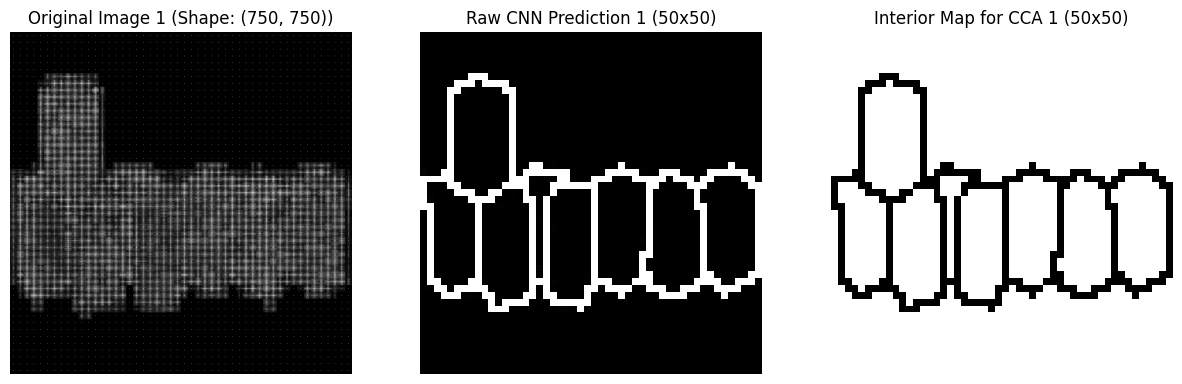

  Found 10 connected components (excluding background).
  Processed Image 1: Found 9 metals to display.
  Saving 9 segments to segmented_metals_image_1/


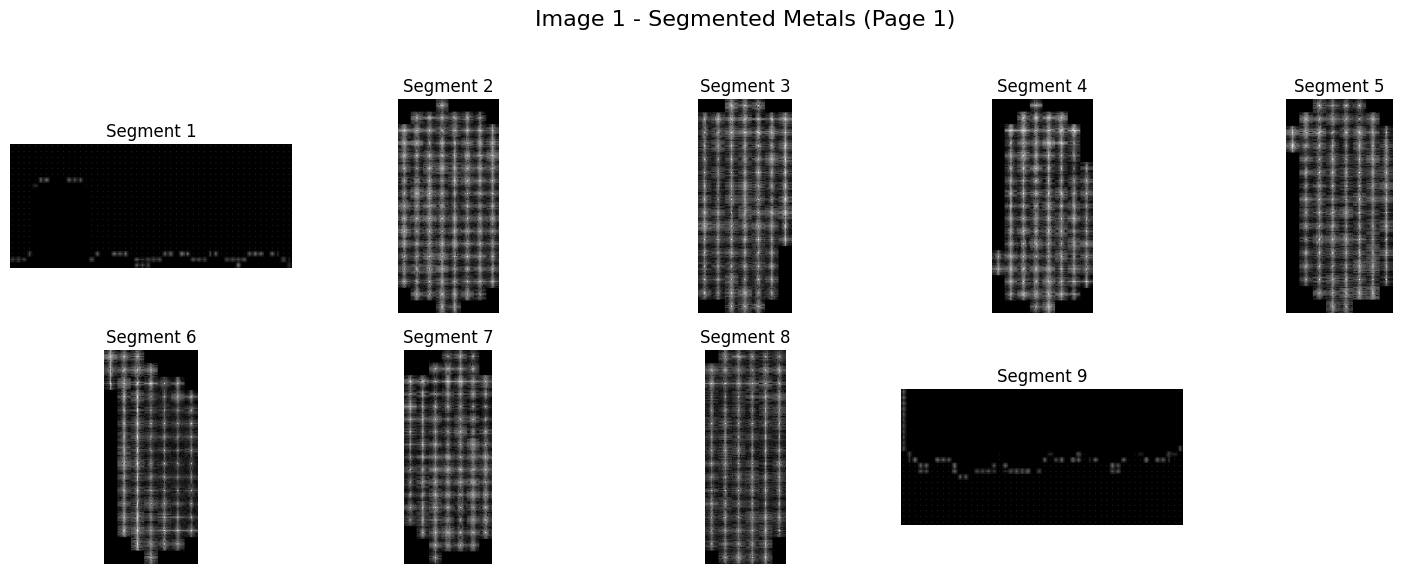

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

--- Processing Image 2 ---


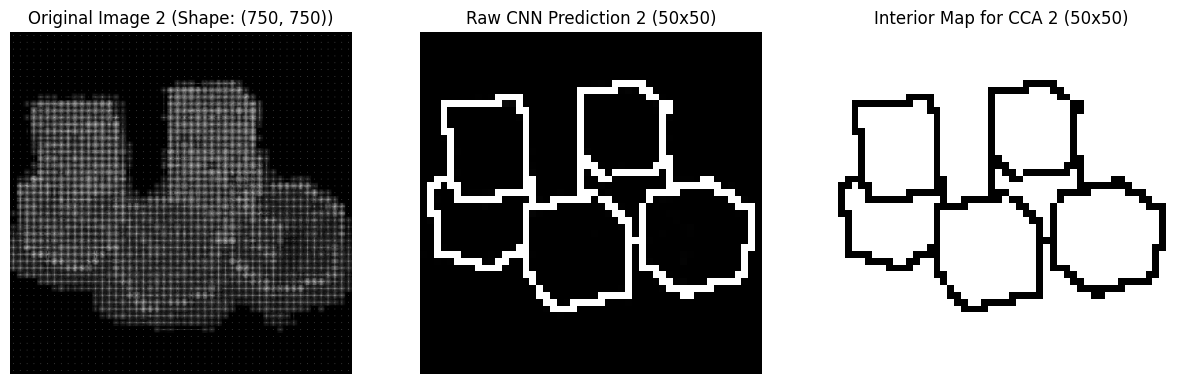

  Found 7 connected components (excluding background).
  Processed Image 2: Found 6 metals to display.
  Saving 6 segments to segmented_metals_image_2/


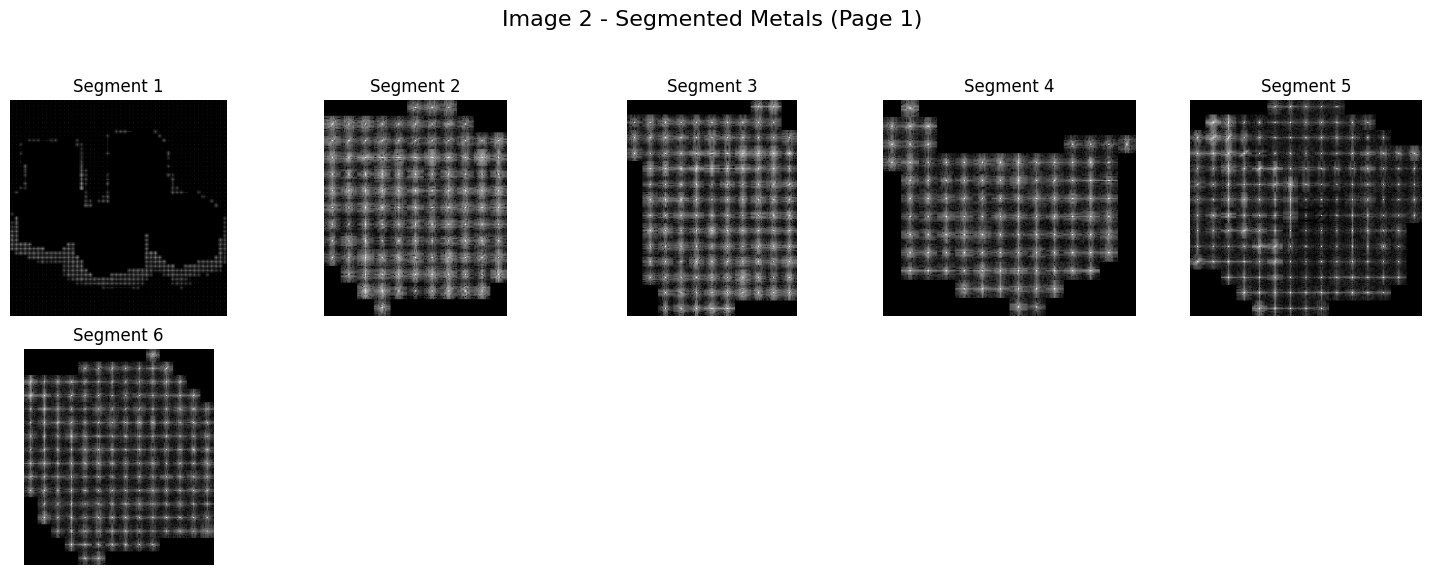

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

--- Processing Image 3 ---


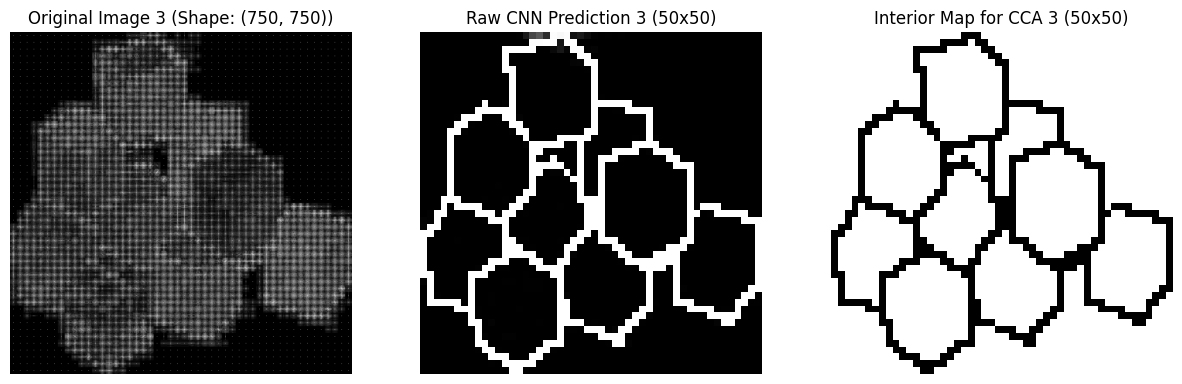

  Found 14 connected components (excluding background).
  Processed Image 3: Found 13 metals to display.
  Saving 13 segments to segmented_metals_image_3/


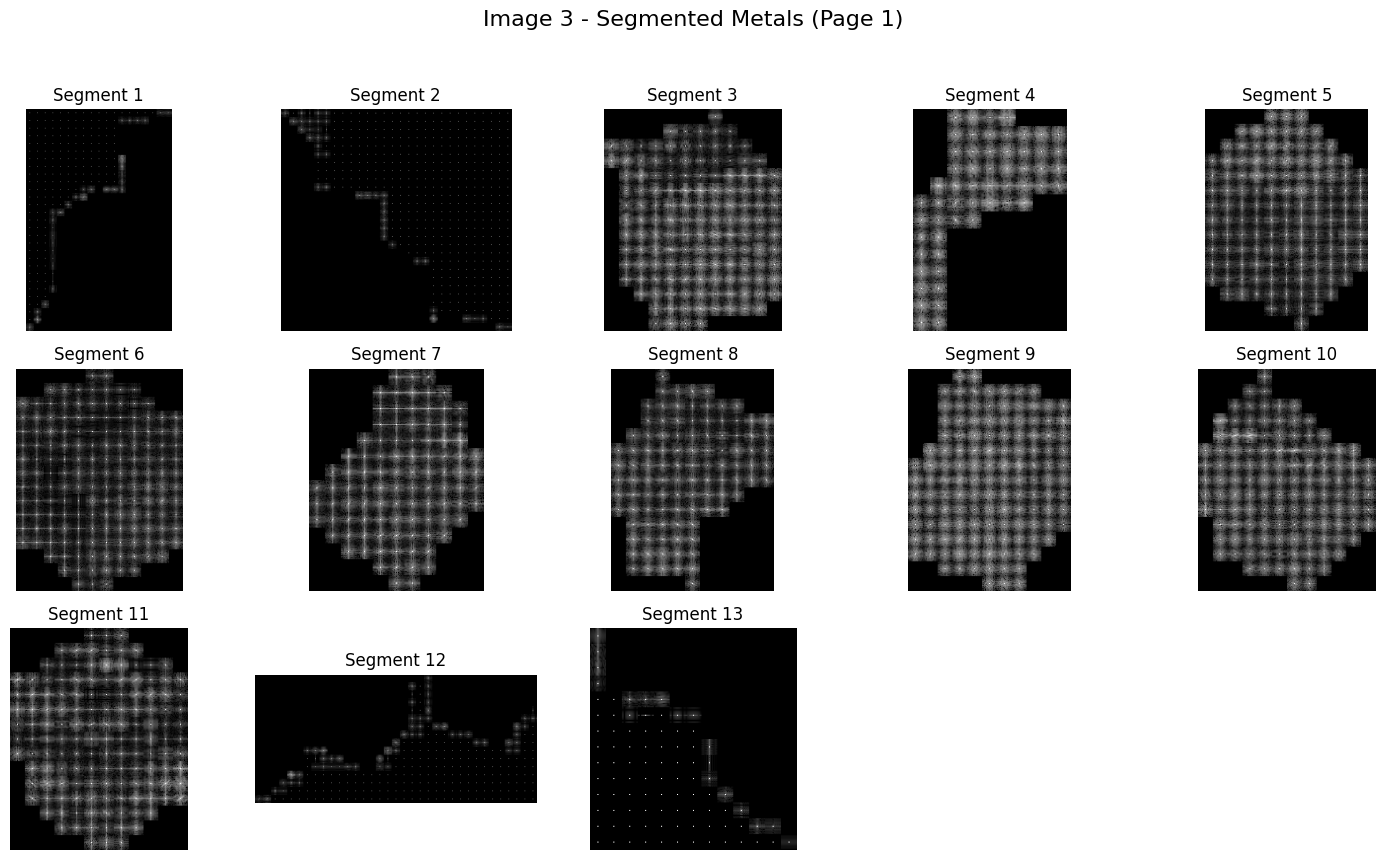

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step

--- Processing Image 4 ---


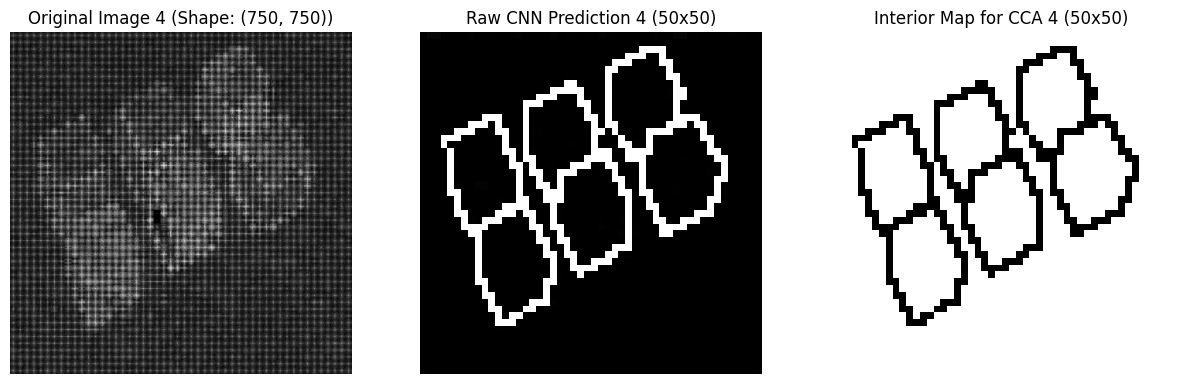

  Found 7 connected components (excluding background).
  Processed Image 4: Found 7 metals to display.
  Saving 7 segments to segmented_metals_image_4/


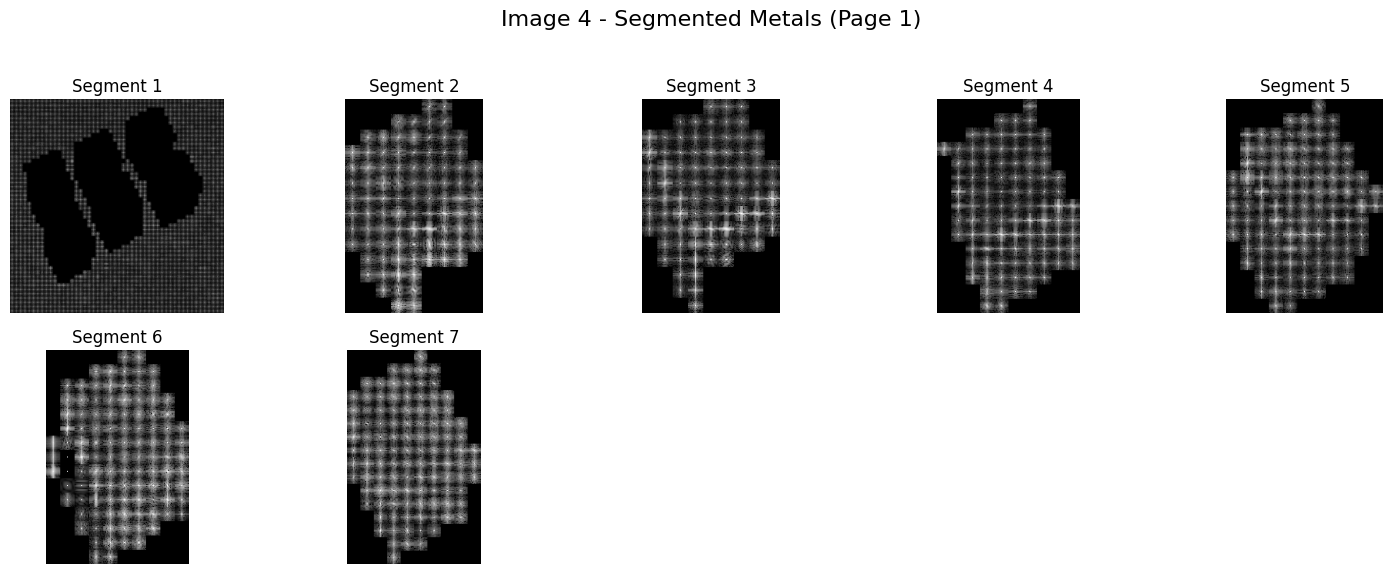


--- All selected images from dataset processed and segments displayed. ---


In [ ]:
print(f"Starting metal object segmentation and display/save process.")

# Set the number of images to process from the dataset.
# Change this value to test with more or fewer images.
num_images_to_process = 5

for image_index, (original_image_tensor, _) in enumerate(dataset.take(num_images_to_process)):
    # Convert the TensorFlow tensor image to a NumPy array for OpenCV processing.
    # [0] is used to extract the single image from the batch.
    original_image_np = original_image_tensor[0].numpy()

    # --- Pre-processing for consistent image size and type ---
    target_height, target_width = 750, 750
    if original_image_np.shape[0] != target_height or original_image_np.shape[1] != target_width:
        print(f"Resizing original image from {original_image_np.shape[:2]} to {target_height}x{target_width}")
        # Resize if dimensions don't match (e.g., if original images vary or model expects fixed size)
        original_image_np = cv2.resize(original_image_np, (target_width, target_height), interpolation=cv2.INTER_AREA)

    # Ensure the image is in 8-bit unsigned integer format (0-255) for OpenCV compatibility.
    if original_image_np.dtype == np.float32:
        original_image_np = (original_image_np * 255).astype(np.uint8)
    elif original_image_np.dtype != np.uint8:
        original_image_np = original_image_np.astype(np.uint8)

    # Prepare the image for model prediction: add batch dimension if needed.
    input_for_prediction = tf.expand_dims(original_image_tensor[0], 0)

    # --- Get 50x50 Prediction from the CNN Model ---
    # The CNN model outputs a 50x50 probability map indicating edges.
    cnn_edge_probability_map_50x50 = model.predict(input_for_prediction)[0]

    # --- Convert Probability Map to Binary Edge Mask (50x50) ---
    # Threshold the probability map: values > 0.5 are considered edges (255), otherwise non-edges (0).
    binary_edge_mask_50x50 = (cnn_edge_probability_map_50x50 > 0.5).astype(np.uint8) * 255

    # --- Create Interior Map for Connected Components Analysis (CCA) ---
    # The CCA algorithm identifies connected regions of 'foreground' pixels.
    # Here, 'foreground' is defined as *non-edge* regions, which correspond to potential object interiors.
    # So, 255 - edge_mask turns edges (255) into black (0) and non-edges (0) into white (255).
    segmentation_input_map_50x50 = 255 - binary_edge_mask_50x50

    # Remove any singleton dimensions if the map is 3D (e.g., 50x50x1 -> 50x50).
    if segmentation_input_map_50x50.ndim == 3 and segmentation_input_map_50x50.shape[2] == 1:
        segmentation_input_map_50x50 = segmentation_input_map_50x50.squeeze(axis=2)

    # --- Calculate Scaling Factors to Map 50x50 Grid to Original 750x750 Resolution ---
    # Each cell in the 50x50 grid corresponds to a block of pixels in the 750x750 image.
    pixel_height_per_grid_cell = original_image_np.shape[0] // segmentation_input_map_50x50.shape[0] # 750 / 50 = 15
    pixel_width_per_grid_cell = original_image_np.shape[1] // segmentation_input_map_50x50.shape[1]   # 750 / 50 = 15

    print(f"\n--- Processing Image {image_index+1} ---")

    # --- Visualize Intermediate Steps (Original, CNN Prediction, Interior Map) ---
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image_np, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {image_index+1} (Shape: {original_image_np.shape[:2]})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cnn_edge_probability_map_50x50.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Raw CNN Edge Prediction {image_index+1} (50x50)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmentation_input_map_50x50, cmap='gray')
    plt.title(f'Binary Non-Edge Map for CCA {image_index+1} (50x50)')
    plt.axis('off')
    plt.show()

    # --- Perform Connected Components Analysis on the 50x50 Grid ---
    # This identifies all distinct regions of non-edge pixels.
    total_components_found, component_labels_map_50x50, component_stats, component_centroids = \
        custom_connected_components_dfs(segmentation_input_map_50x50, connectivity=4)

    print(f"  Found {total_components_found - 1} connected components (excluding background label 0).")

    # List to store the final cropped and isolated metal objects
    detected_metal_segments = []

    # Iterate through each identified component (starting from label 1, as 0 is background)
    for current_component_label in range(1, total_components_found):
        # Extract the area of the current component from the 'component_stats' array.
        # 'area' is given in terms of the number of 50x50 grid cells.
        component_area_in_grid_cells = component_stats[current_component_label, cv2.CC_STAT_AREA]

        # --- IMPORTANT: Area Thresholding for Filtering ---
        # This is crucial for filtering out:
        # 1. Very small noise components (e.g., single stray pixels).
        # 2. Large background regions that the edge detection didn't completely enclose.
        #
        # 'area > 50' means only components larger than 50 grid cells are considered.
        # (1 grid cell = 15x15 pixels = 225 original pixels).
        # So, 'area > 50' means component must be > 50 * 225 = 11,250 original pixels.
        #
        # You MUST TUNE this value (50) based on your dataset:
        # - Increase it if you still see large, blank background segments being detected.
        # - Decrease it if small, legitimate metal objects are being filtered out.
        if component_area_in_grid_cells > 50:
            # --- Create a Full-Resolution Mask for the Current Component ---
            # This mask will be used to extract the corresponding pixels from the original 750x750 image.
            component_mask_full_resolution = np.zeros(original_image_np.shape[:2], dtype=np.uint8)

            # Map the pixels of the current 50x50 component back to the full 750x750 resolution.
            # Each 50x50 cell is expanded to its corresponding 15x15 pixel block.
            for grid_row in range(component_labels_map_50x50.shape[0]):
                for grid_col in range(component_labels_map_50x50.shape[1]):
                    # If this 50x50 grid cell belongs to the current component:
                    if component_labels_map_50x50[grid_row, grid_col] == current_component_label:
                        # Calculate the pixel coordinates for the top-left corner of this grid cell's block.
                        pixel_y_start = grid_row * pixel_height_per_grid_cell
                        pixel_x_start = grid_col * pixel_width_per_grid_cell

                        # Calculate the pixel coordinates for the bottom-right corner of this grid cell's block.
                        pixel_y_end = pixel_y_start + pixel_height_per_grid_cell
                        pixel_x_end = pixel_x_start + pixel_width_per_grid_cell

                        # Set the corresponding block in the full-resolution mask to 255 (white/foreground).
                        component_mask_full_resolution[pixel_y_start:pixel_y_end, pixel_x_start:pixel_x_end] = 255

            # --- Isolate the Object from the Original Image using the Full-Resolution Mask ---
            # This operation keeps only the pixels from the original image that correspond
            # to the current connected component, setting everything else to black.
            original_image_masked_component = cv2.bitwise_and(original_image_np, original_image_np, mask=component_mask_full_resolution)

            # --- Find Tight Bounding Box and Crop the Isolated Object ---
            # Find all non-zero (foreground) pixel coordinates in the full-resolution mask.
            # This helps to get a precise bounding box, even if the mask is a bit irregular.
            nonzero_pixel_coordinates = cv2.findNonZero(component_mask_full_resolution)

            if nonzero_pixel_coordinates is not None:
                # Calculate the bounding rectangle (x, y, width, height) around the non-zero pixels.
                # x, y are the top-left corner coordinates of the bounding box.
                x_bbox, y_bbox, w_bbox, h_bbox = cv2.boundingRect(nonzero_pixel_coordinates)

                # Crop the isolated object image to this tight bounding box.
                final_segmented_object_crop = original_image_masked_component[y_bbox:y_bbox+h_bbox, x_bbox:x_bbox+w_bbox]

                # Add the final cropped object to the list of detected metal segments.
                detected_metal_segments.append(final_segmented_object_crop)
            else:
                # This warning means a component passed the area threshold but had no pixels in its full-res mask.
                # This is highly unlikely if the area threshold is correctly set.
                print(f"  Warning: Component {current_component_label} had no non-zero pixels in its full-res mask. Skipping display.")

    print(f"  Processed Image {image_index+1}: Found {len(detected_metal_segments)} metal objects to display/save.")

    # --- Save Segments to Disk ---
    if detected_metal_segments:
        # Create a unique directory for segments from the current image
        output_directory_for_image = f"segmented_metals_image_{image_index+1}"
        os.makedirs(output_directory_for_image, exist_ok=True) # Ensures directory exists

        print(f"  Saving {len(detected_metal_segments)} segments to '{output_directory_for_image}/'")

        for segment_index, current_segment_image in enumerate(detected_metal_segments):
            # Construct filename for each segment (e.g., "segmented_metals_image_1/segment_1.png")
            segment_filename = os.path.join(output_directory_for_image, f"segment_{segment_index + 1}.png")
            cv2.imwrite(segment_filename, current_segment_image) # Save the image file

    # --- Display Segments using Matplotlib ---
    if detected_metal_segments:
        # Determine optimal grid layout for displaying multiple segments
        num_segments_to_display = len(detected_metal_segments)
        display_cols = 5 # Number of segments per row in the plot
        display_rows = (num_segments_to_display + display_cols - 1) // display_cols # Calculate required rows

        # Handle multiple figures if there are many segments
        current_figure = None
        current_subplot_position = 0

        for segment_index, current_segment_image in enumerate(detected_metal_segments):
            # Create a new figure if no current figure exists or if the current one is full
            if current_figure is None or current_subplot_position >= (display_rows * display_cols):
                if current_figure is not None:
                    plt.tight_layout() # Adjust layout for current figure
                    plt.show() # Display the full figure before starting a new one

                current_figure = plt.figure(figsize=(display_cols * 3, display_rows * 3)) # Adjust figure size dynamically
                current_figure.suptitle(f'Image {image_index+1} - Segmented Metal Objects (Page {segment_index // (display_rows * display_cols) + 1})', fontsize=16)
                current_subplot_position = 0 # Reset subplot counter for the new figure

            current_subplot_position += 1
            ax = current_figure.add_subplot(display_rows, display_cols, current_subplot_position)
            ax.imshow(cv2.cvtColor(current_segment_image, cv2.COLOR_BGR2RGB)) # Display the segment
            ax.set_title(f'Object {segment_index + 1}') # Title for each segment subplot
            ax.axis('off') # Hide axes for cleaner display

        # Display the last figure (or the only figure if all segments fit on one page)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

    else:
        print(f"  No metal segments found above the area threshold for Image {image_index+1}.")

print("\n--- All selected images from dataset processed, segments extracted, displayed, and saved. ---")